In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision

# 一、前期准备

## 1.设置GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

## 2.导入数据

In [4]:
train_ds = torchvision.datasets.MNIST('data', 
                                      train=True, 
                                      transform=torchvision.transforms.ToTensor(), 
                                      download=False)

test_ds = torchvision.datasets.MNIST('data', 
                                     train=False, 
                                     transform=torchvision.transforms.ToTensor(), 
                                     download=False)

In [5]:
batch_size = 32

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

In [6]:
imgs, labels = next(iter(train_dl))
imgs.shape

torch.Size([32, 1, 28, 28])

## 3.数据可视化

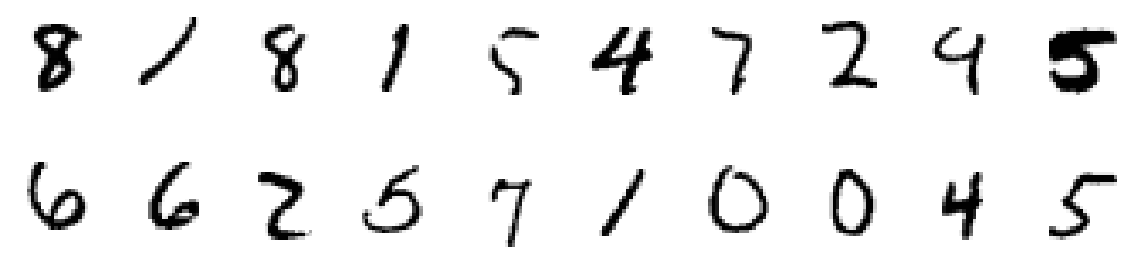

In [7]:
import numpy as np

plt.figure(figsize=(20, 5))
for i, img in enumerate(imgs[:20]):
    # 维度缩减
    npimg = np.squeeze(img.numpy())
    
    plt.subplot(2, 10, i+1)
    plt.imshow(npimg, cmap=plt.cm.binary)
    plt.axis('off')

# 二、构建简单的CNN网络

![CNN](./fig/cnn.jpg)

![LeNet-5](https://pic4.zhimg.com/80/v2-d8d121a8013115a41ac5396cbf31943b_1440w.webp)

In [8]:
import torch.nn.functional as F

num_classes = 10 # 图片类别数

class LeNet_5(nn.Module):
    """LetNet-5"""
    def __init__(self):
        super().__init__()
        
        # 特征提取网络
        self.feature_net = nn.Sequential(*[nn.Conv2d(1, 32, kernel_size=3), 
                            nn.ReLU(),
                            nn.MaxPool2d(2),
                            nn.Conv2d(32, 64, kernel_size=3),
                            nn.ReLU(),
                            nn.MaxPool2d(2)])
        
        # 分类网络
        self.classes_net = nn.Sequential(nn.Linear(1600, 64), 
                                         nn.ReLU(), 
                                         nn.Linear(64, num_classes))
        
    def forward(self, x):
        x = self.feature_net(x)
        
        x = torch.flatten(x, start_dim=1)
        
        x = self.classes_net(x)
        
        return x

In [9]:
from torchinfo import summary

model = LeNet_5().to(device)

summary(model)

Layer (type:depth-idx)                   Param #
LeNet_5                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       18,496
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-7                       102,464
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       650
Total params: 121,930
Trainable params: 121,930
Non-trainable params: 0

# 三、训练模型

## 1. 设置超参数

In [18]:
loss_fn = nn.CrossEntropyLoss()
lr = 1e-2
opt = torch.optim.SGD(model.parameters(), lr=lr)

## 2.编写训练函数

In [14]:
# 训练循环
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # 训练集大小，一共60000张图片
    num_batches = len(dataloader) # 批次数目，1875（60000 / 32）
    
    train_loss, train_acc = 0, 0
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X) # 网络输出
        loss = loss_fn(pred, y)
        
        # back
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 记录acc和loss
        train_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
        
    train_acc /= size
    train_loss /= num_batches
    
    return train_acc, train_loss

## 3.编写测试函数

In [15]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_acc, test_loss = 0, 0
    
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc += (target_pred.argmax(1) == target).type(torch.float).sum().item()
            
    test_acc /= size
    test_loss /= num_batches
    
    return test_acc, test_loss

## 4.正式训练

In [19]:
epochs = 5
train_loss, train_acc = [], []
test_loss, test_acc = [], []

for epoch in range(epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}% Test_loss:{:.3f}')
    print(template.format(epoch+1, 
                          epoch_train_acc*100, epoch_train_loss, 
                          epoch_test_acc*100, epoch_test_loss))
print("Done")

Epoch: 1, Train_acc:92.4%, Train_loss:0.245, Test_acc:95.4% Test_loss:0.150
Epoch: 2, Train_acc:95.9%, Train_loss:0.135, Test_acc:97.1% Test_loss:0.097
Epoch: 3, Train_acc:96.9%, Train_loss:0.101, Test_acc:97.5% Test_loss:0.076
Epoch: 4, Train_acc:97.5%, Train_loss:0.081, Test_acc:97.8% Test_loss:0.071
Epoch: 5, Train_acc:97.8%, Train_loss:0.071, Test_acc:98.1% Test_loss:0.059


# 四、结果可视化

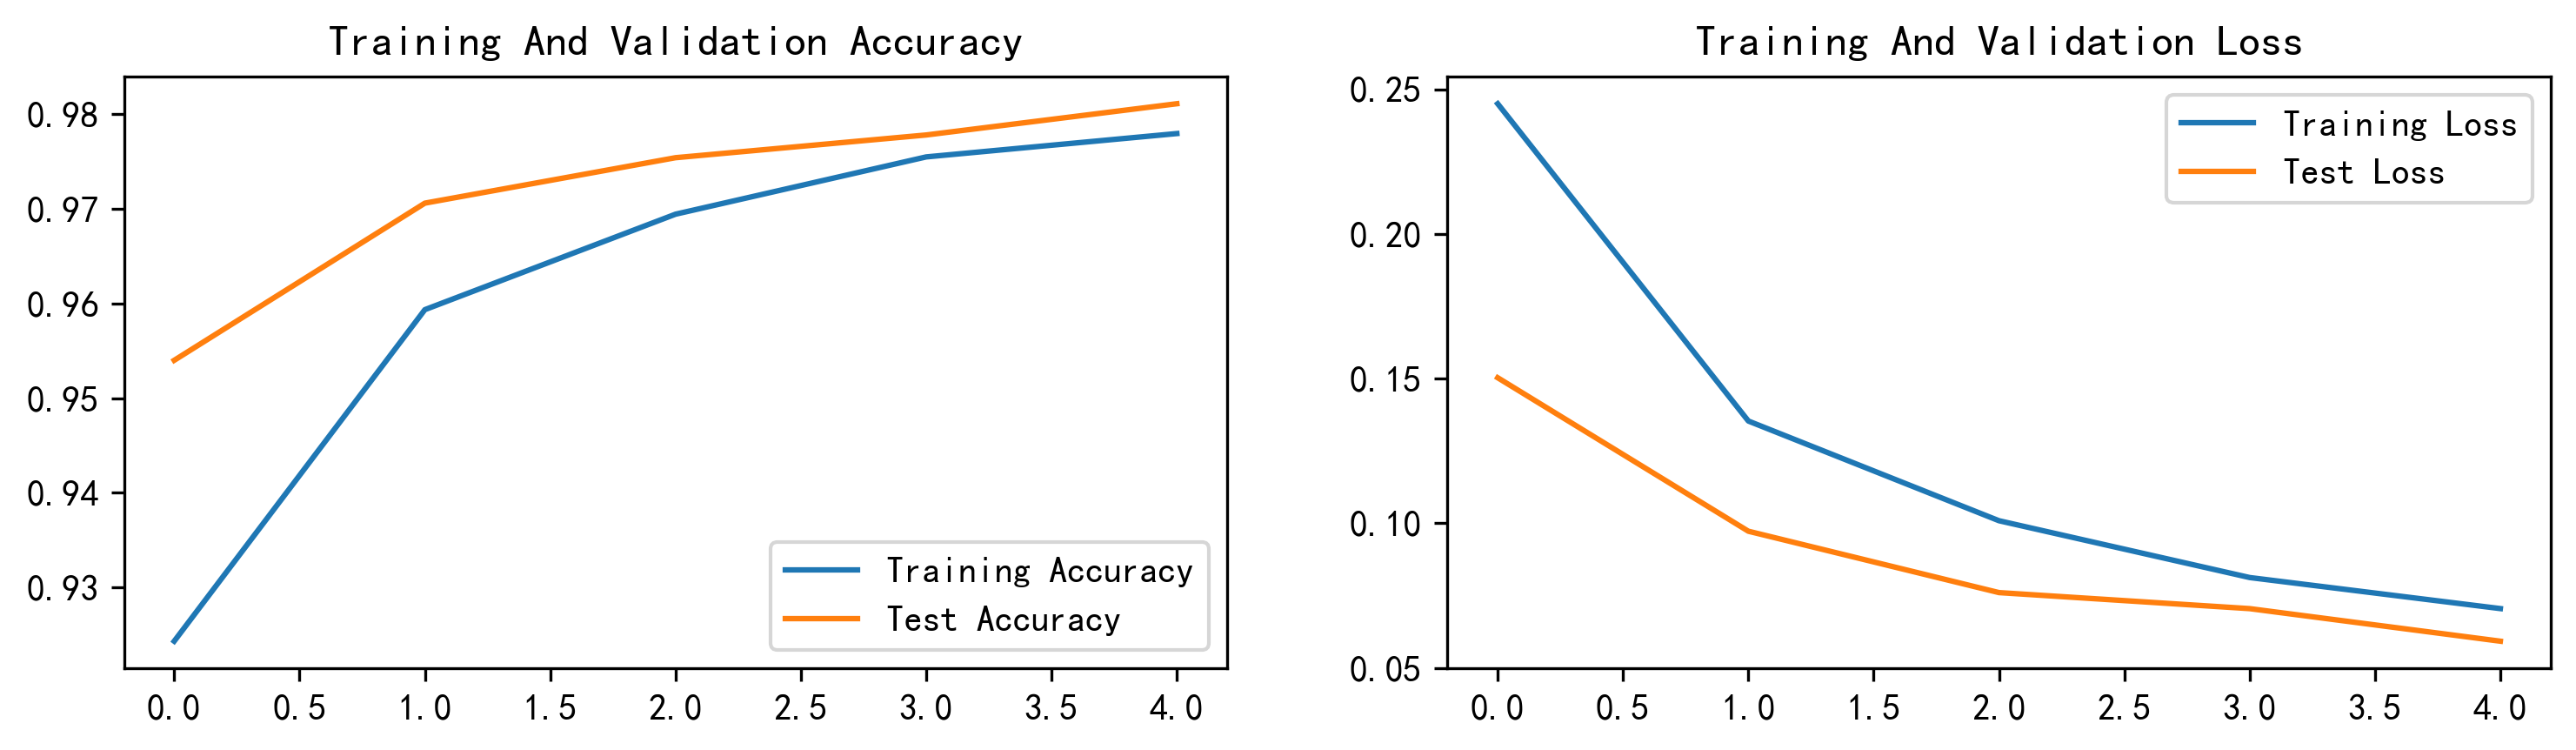

In [21]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # 忽略警告信息

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300

epoch_range = range(epochs)

plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_acc, label='Training Accuracy')
plt.plot(epoch_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training And Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epoch_range, train_loss, label='Training Loss')
plt.plot(epoch_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training And Validation Loss')

plt.show()

# 五、预测

In [41]:
def predict_num(model, test_data, index):
    pre = model(test_data.to(device))
    num, ph = 0, 0;
    for i, p in enumerate(pre[index]):
        if p > ph:
            ph = p
            num = i
            
    return num, ph

In [22]:
img_, label_ = next(iter(test_dl))

tensor(9)

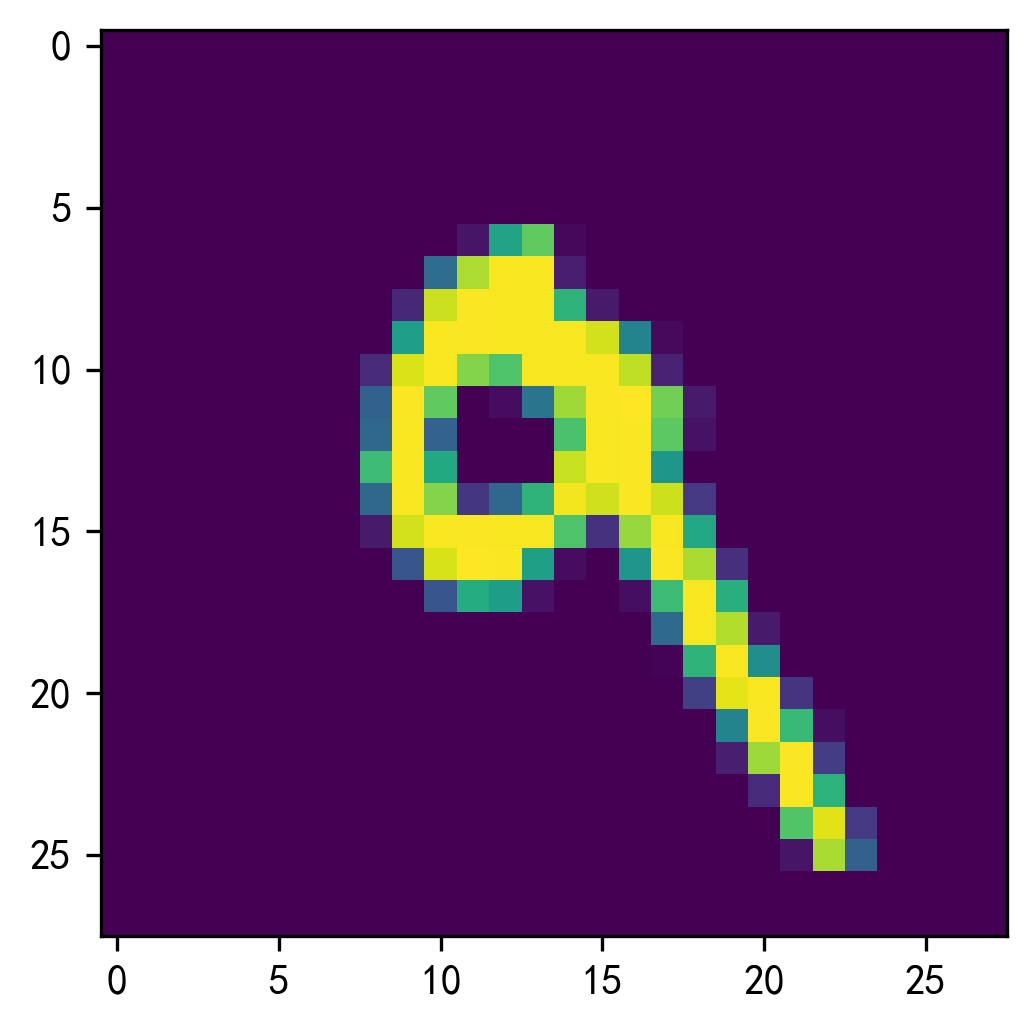

In [44]:
plt.imshow(np.squeeze(img_[7]))
label_[7]

In [42]:
predict_num(model, img_, 7)

(9, tensor(7.8956, device='cuda:0', grad_fn=<UnbindBackward0>))